In [1]:
#MODIFIED LOSS
#MIXUP
#image with padding 1

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
os.chdir('..')
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks import TrackerCallback
from fastai.callbacks import CSVLogger
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from utils.mxresnet import *
from utils.ranger import *
from sklearn.model_selection import StratifiedKFold, KFold
from joblib import load, dump
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pretrainedmodels
from utils.augment import *

In [2]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [3]:
FOLD = 2
NAME = 'EXP_200'
SUFFIX =f'RESNEX_1CH_MISH_SIMPLE_RICAP_CLASS_1_{FOLD}'
PATH = Path('../../../bengaliai')
SZ = 128
BS = 1024
NFOLDS = 5 #keep the same split as the initial dataset
SEED = 2019
TRAIN_IMG = PATH/'img_trn_orig'
LABELS = PATH/'train.csv'

os.chdir(NAME)

In [4]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def multi_strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [5]:
df = pd.read_csv(str(LABELS))
nunique = list(df.nunique())[1:-1]

In [6]:
val_idx = multi_strt_split(df['image_id'], df[df.columns[1:-1]].get_values())[FOLD]

/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  """Entry point for launching an IPython kernel.


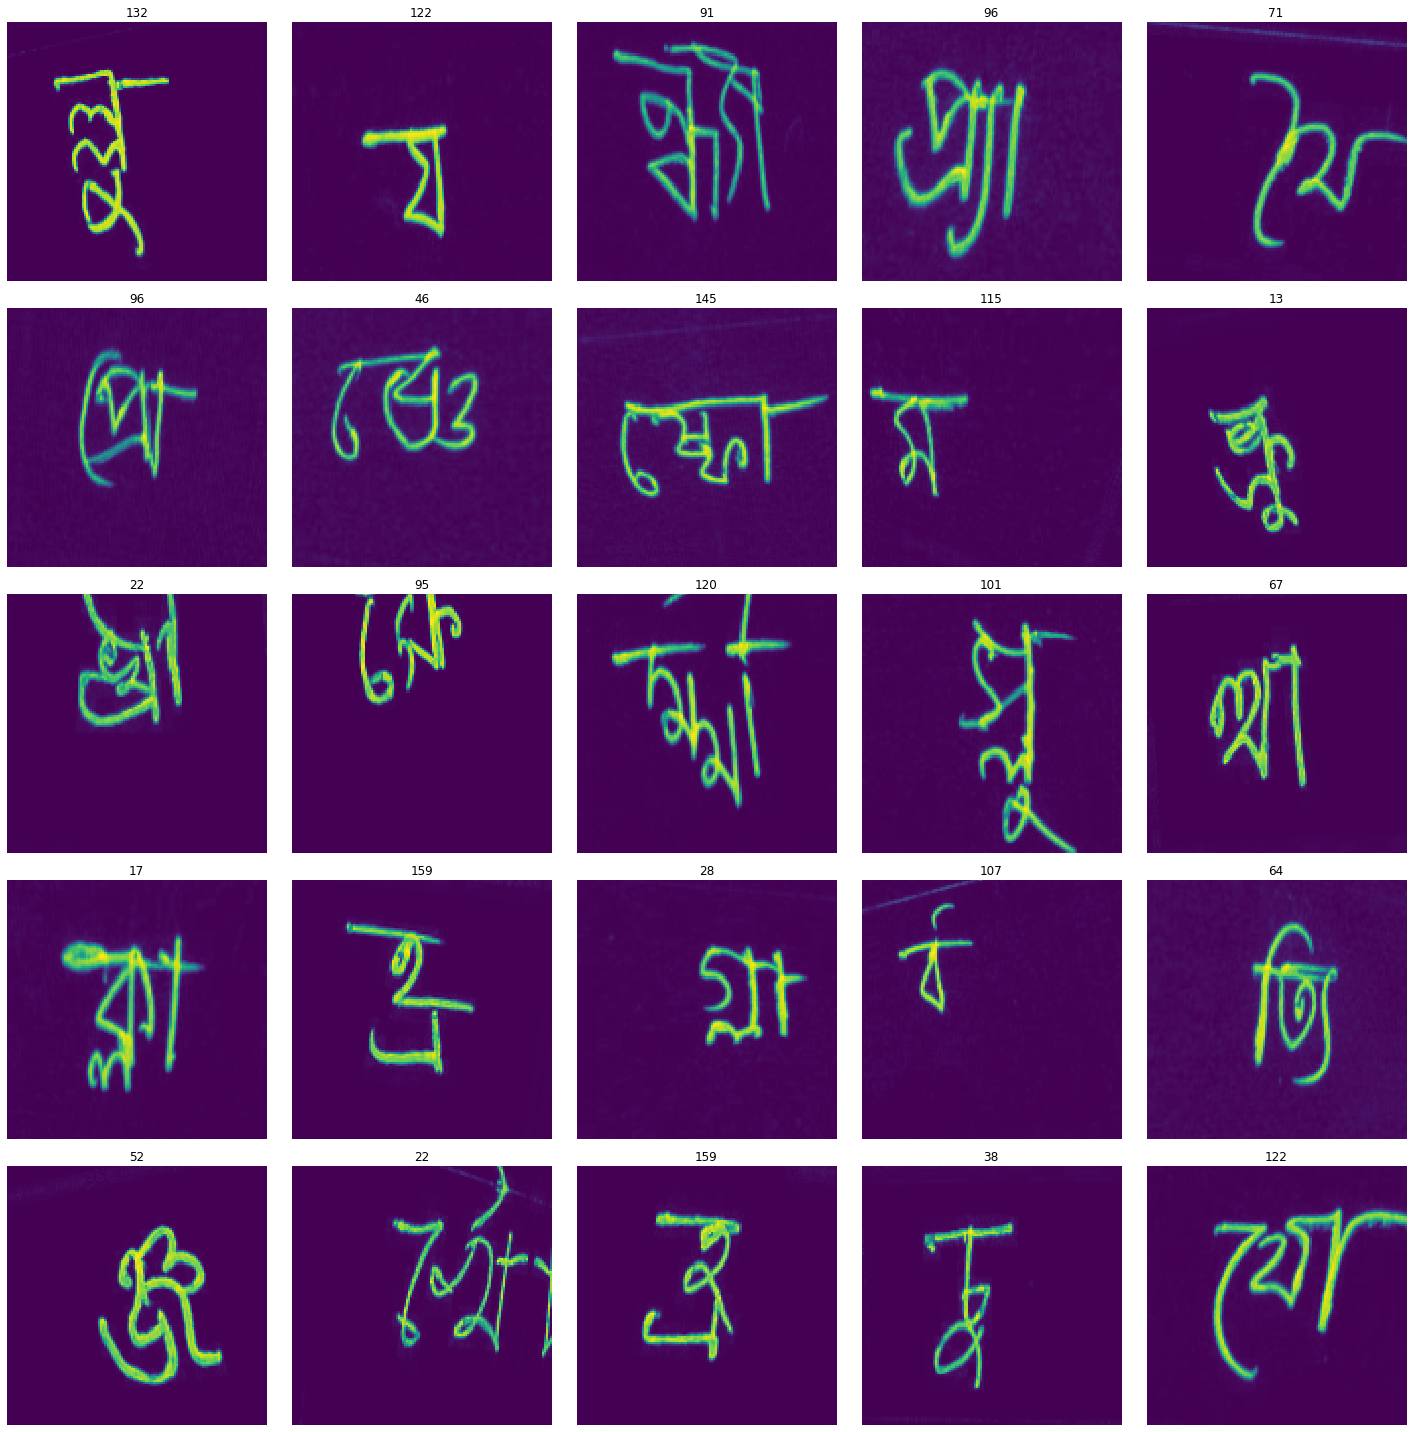

In [7]:
#imagenet_stats
data = (ImageList.from_df(df, path='', folder=TRAIN_IMG, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols=['grapheme_root']) #'vowel_diacritic','consonant_diacritic'
        .transform(get_transforms(do_flip=False,max_warp=0.2, max_zoom=1.1, max_rotate=10), size=(SZ, SZ), resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
        .databunch(bs=BS)).normalize(([0.0692], [0.2051]))

data.show_batch()

In [8]:
stats_ = data.stats
stats_
#size=(137, 236)

([0.0692], [0.2051])

In [9]:
class Head(nn.Module):
    def __init__(self, nc, n, ps=0.2):
        super().__init__()
        layers = [AdaptiveConcatPool2d(), Mish(), Flatten()] + \
            bn_drop_lin(nc*2, 512, True, ps, nn.ReLU(inplace=True)) + \
            bn_drop_lin(512, n, True, ps)
        self.fc = nn.Sequential(*layers)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)
    
    
    
class CustomHead(nn.Module):
    def __init__(self, arch, cut, nc, n=nunique, pre=False, ps=0.5, activ_mish=True):
        super().__init__()
        self.body=nn.Sequential(*list(arch.children())[:cut])
        self.head1 = Head(nc,n[0])
        self.head2 = Head(nc,n[1])
        self.head3 = Head(nc,n[2])
        if activ_mish: 
            to_Mish(self.head1), to_Mish(self.head2), to_Mish(self.head3)
        
    def forward(self, x):
        x = self.body(x)
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        return x1, x2, x3

In [10]:
arch = pretrainedmodels.se_resnext50_32x4d(num_classes=1000)
arch = list(arch.children())
w = arch[0][0].weight
arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=2, bias=False)
arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
arch = nn.Sequential(*arch)
arch = nn.Sequential(*list(arch.children())[:-2], 
                            AdaptiveConcatPool2d(),
                            Flatten(), 
                            nn.BatchNorm1d(4096),
                            nn.Dropout(p=0.25),
                            nn.Linear(in_features=4096, 
                            out_features=512), 
                            nn.ReLU(inplace=True),
                            nn.BatchNorm1d(512), 
                            nn.Dropout(p=0.5),
                            nn.Linear(in_features=512, out_features=data.c))

In [11]:
class Metric_idx(Callback):
    def __init__(self, average='macro'):
        super().__init__()
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output
        last_target = last_target
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx)

In [12]:
learn = Learner(data, arch, opt_func = Over9000, 
        metrics=[Metric_grapheme()]).ricap()

learn.unfreeze()
learn.model = nn.DataParallel(learn.model)
#learn.lr_find(wd=1e-2)

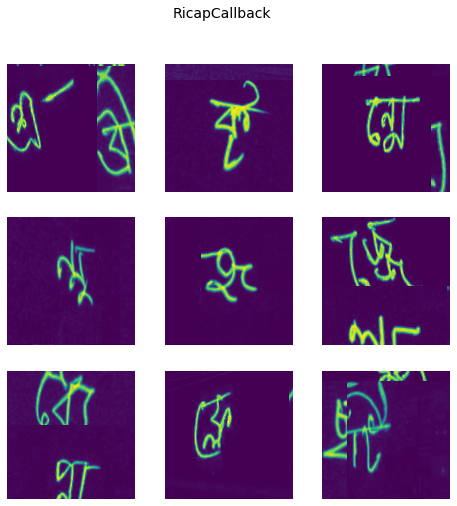

In [13]:
learn.show_tfms();

In [14]:
learn.unfreeze()
lr = 1e-1/4
learn.fit_one_cycle(100, lr, wd=1e-2,  pct_start=0.0,  div_factor=100, callbacks = [SaveModelCallback(learn, every='improvement', monitor='metric_idx', name = f'{NAME}_{SUFFIX}_{FOLD}')])

epoch,train_loss,valid_loss,metric_idx,time
0,0.616027,0.695805,0.789962,04:16
1,0.489967,0.456118,0.876269,03:59
2,0.448838,0.448730,0.907638,04:00
3,0.485714,0.549421,0.908251,03:59
4,0.446122,0.499611,0.919719,03:59
5,0.397522,0.431174,0.918855,03:59
6,0.376903,0.412136,0.934919,03:59
7,0.415317,0.394181,0.937035,04:00
8,0.387419,0.421043,0.935459,03:59
9,0.391707,0.353499,0.941383,04:00


Better model found at epoch 0 with metric_idx value: 0.7899619340896606.
Better model found at epoch 1 with metric_idx value: 0.8762694001197815.
Better model found at epoch 2 with metric_idx value: 0.9076377153396606.
Better model found at epoch 3 with metric_idx value: 0.908250629901886.
Better model found at epoch 4 with metric_idx value: 0.9197188019752502.
Better model found at epoch 6 with metric_idx value: 0.9349185228347778.
Better model found at epoch 7 with metric_idx value: 0.9370353817939758.
Better model found at epoch 9 with metric_idx value: 0.9413829445838928.
Better model found at epoch 10 with metric_idx value: 0.9432337880134583.
Better model found at epoch 13 with metric_idx value: 0.9443163275718689.
Better model found at epoch 16 with metric_idx value: 0.9471162557601929.
Better model found at epoch 18 with metric_idx value: 0.9473834037780762.
Better model found at epoch 26 with metric_idx value: 0.9477314949035645.
Better model found at epoch 27 with metric_idx 

In [15]:
!sudo shutdown

Shutdown scheduled for Mon 2020-01-27 04:15:30 UTC, use 'shutdown -c' to cancel.
